In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Categorical
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import interpolate
import pickle
import matplotlib.pyplot as plt

In [2]:
#Actor network class created below

class Actor(nn.Module):
    def __init__(self, in_dim: int, out_dim: int,):
        
        self.in_dim=in_dim
        self.out_dim=out_dim
        
        super(Actor, self).__init__()

        self.hidden_one = nn.Linear(in_dim, 320)
        self.hidden_two = nn.Linear(320,320)
        self.mu_layer = nn.Linear(320, out_dim)
        self.log_std_layer = nn.Linear(320, out_dim)

    def forward(self, state: torch.Tensor):
        
        x = F.tanh(self.hidden_one(state))
        x = F.tanh(self.hidden_two(x))
        
        mu = torch.tanh(self.mu_layer(x))
        log_std = torch.tanh(self.log_std_layer(x))

        std = torch.exp(log_std)
        dist = Normal(mu, std)
        action = dist.sample()

        return action, dist, mu, std
    
#Critic network class created below    

class Critic(nn.Module):
    def __init__(self, in_dim: int):
        super(Critic, self).__init__()

        self.hidden_one = nn.Linear(in_dim, 320)
        self.hidden_two = nn.Linear(320,320)
        self.out = nn.Linear(320, 1)

    def forward(self, state: torch.Tensor) -> torch.Tensor:

        x = F.relu(self.hidden_one(state))
        x = F.relu(self.hidden_two(x))
        value = self.out(x)

        return value

In [3]:
class PPO_Agent(object):
    def __init__(self, obs_dim=3, act_dim =3, gamma =0.99,lamda =0.9,
                 entropy_coef =0.01,epsilon =0.2, value_range =0.2,
                 num_epochs =10, batch_size =30, actor_lr =0.001, critic_lr =0.001):
        
        self.gamma=gamma
        self.lamda=lamda
        self.entropy_coef=entropy_coef
        self.epsilon=epsilon
        self.value_range=value_range
       
        self.num_epochs=num_epochs
        self.batch_size=batch_size
        
        self.obs_dim=obs_dim
        self.act_dim=act_dim
        self.actor_lr=actor_lr
        self.critic_lr=critic_lr
        
        self.actor=Actor(self.obs_dim,self.act_dim)
        self.critic=Critic(self.obs_dim)
        self.actor_optimizer=optim.Adam(self.actor.parameters(),lr=self.actor_lr)
        self.critic_optimizer=optim.Adam(self.critic.parameters(),lr=self.critic_lr)
        
        self.states = []
        self.actions = []
        self.rewards = []
        self.is_terminals = []
        self.log_probs = []
        self.values = []
        self.next_states=[]
        
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        
    def clear_memory(self):
    
        self.states = []
        self.actions = []
        self.rewards = []
        self.is_terminals = []
        self.log_probs = []
        self.values = []
        self.next_states= []
        
    def get_gae(self, rewards: list, values: list, is_terminals: list, gamma: float, lamda: float,):
        
        gae = 0
        returns = []
    
        for i in reversed(range(len(rewards))):
            delta = (rewards[i] + gamma * values[i + 1] * is_terminals[i] - values[i])
            gae = delta + gamma * lamda * is_terminals[i] * gae
            return_=np.array([gae+values[i]])
            returns.insert(0, return_)

        return returns
    
    def trajectories_data_generator(self, states: torch.Tensor,actions: torch.Tensor,
                                returns: torch.Tensor,log_probs: torch.Tensor,
                                values: torch.Tensor,advantages: torch.Tensor,
                                batch_size, num_epochs,):
        data_len = states.size(0)
        for _ in range(num_epochs):
            for _ in range(data_len // batch_size):
                ids = np.random.choice(data_len, batch_size)
                yield states[ids, :], actions[ids], returns[ids], log_probs[ids], values[ids], advantages[ids]

        
    def _get_action(self,state):
        
        state = torch.FloatTensor(state).to(self.device)
        action,dist,mu,std=self.actor.forward(state)   
        value=self.critic.forward(state)
        
        return action, value, dist, mu, std
    
    
    def _update_weights(self):
        
        self.rewards=torch.tensor(self.rewards).float()
        self.is_terminals=torch.tensor(self.is_terminals).float()
        self.values=torch.tensor(self.values).float()
        self.states=torch.tensor(self.states).float()
        self.log_probs=torch.tensor(self.log_probs).float()
        self.actions=torch.tensor(self.actions).float()
        
        returns = self.get_gae(self.rewards, self.values,self.is_terminals,
                          self.gamma,self.lamda,)
        returns=torch.tensor(returns).float()

        states=self.states
        actions=self.actions
        log_probs=self.log_probs
        values=self.values
        advantages = returns - values[:-1]

        for state, action, return_, old_log_prob, old_value, advantage in self.trajectories_data_generator(
            states=states,actions=actions,returns=returns,log_probs=log_probs,values=values,
            advantages=advantages, batch_size=self.batch_size,num_epochs=self.num_epochs,):

            # compute ratio (pi_theta / pi_theta__old)
            _, dist,__,___ = self.actor(state)
            cur_log_prob = dist.log_prob(action)
            ratio = torch.exp(cur_log_prob - old_log_prob)

            # compute entropy
            entropy = dist.entropy().mean()

            # compute actor loss
            loss =  advantage * ratio
            clipped_loss = (torch.clamp(ratio, 1. - self.epsilon, 1. + self.epsilon)
                            * advantage)
            actor_loss = (-torch.mean(torch.min(loss, clipped_loss))
                          - entropy * self.entropy_coef)
            
            # critic loss, uncoment for clipped value loss too.
            cur_value = self.critic(state)
            clipped_value = (
                old_value + torch.clamp(cur_value - old_value,
                                        -self.value_range, self.value_range)
               )
            loss = (return_ - cur_value).pow(2)
            clipped_loss = (return_ - clipped_value).pow(2)
            critic_loss = torch.mean(torch.max(loss, clipped_loss))

            critic_loss = (return_ - cur_value).pow(2).mean()

            # actor optimizer step
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # critic optimizer step
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
            
        self.clear_memory()
        
    def _save_weights(self,policy_num: int):
            
        filename_actor="Actor_Policy_Number_"+str(policy_num)
        filename_critic="Critic_Policy_Number_"+str(policy_num)
        torch.save(self.actor.state_dict(),filename_actor)
        torch.save(self.critic.state_dict(),filename_critic)
        
    def _load_weights(self,filename_actor,filename_critic):
            
        self.actor.load_state_dict(torch.load(filename_actor))
        self.actor.eval()
        self.critic.load_state_dict(torch.load(filename_critic))
        self.actor.eval()
            

In [4]:
def PI_Motor(w_des_two,tsteps,dt,w0): 
    
    w_des_one=np.zeros(50)
    for i in range(len(w_des_one)):
        if i<=20:
            w_des_one[i]=0
        else:
            w_des_one[i]=w0

    w_des=np.zeros(len(w_des_one)+len(w_des_two))
    for i in range(len(w_des)):
        if i<len(w_des_one):
            w_des[i]=w_des_one[i]
        else:
            w_des[i]=w_des_two[i-len(w_des_one)]
    
    tsteps=tsteps+len(w_des_one)
    
    #Simulation
    # Motor Parameters
    Ke = 0.021199438  # V/rad/s
    Kt = 0.0141937  # Nm/A
    b = 0.0001011492  # Nm/rad/s
    L = 0.00075  # H
    J = 0.00000109445  # kgm^2
    R = 1.56  # ohms
    V_max = 36
    V_min = -V_max
    
    # simulation time parameters
    tf = dt * (tsteps - 1)
    t_sim = np.linspace(0, tf, tsteps)
    
    #PID parameters
    error_s = np.zeros(tsteps)
    V_bias = 0
    tau_i = 30
    sum_int = 0.0
    
    #Initial Conditions
    i0=0
    w0=0
    
    #Tunable parameters
    Kp = 0.270727147578817
    Ki = 50.0897752327866
    Kd = 0.000141076220179068
    N = 248711.202620588 #Filter coefficient for filtered derivative
    
    # Motor input
    V_in = np.zeros(tsteps)
    
    # ODE Output Storage
    w_s = np.zeros(tsteps)
    i_s = np.zeros(tsteps)
    
    # DC Motor Model ODEs
    def motor_electrical(i, t, V, w):
        di_dt = (V - R * i - Ke * w) / L
        return di_dt
    
    def motor_mechanical(w, t, i):
        dw_dt = (Kt * i - b * w) / J
        return dw_dt
    
    # sim_loop
    for n in range(tsteps - 1):
        # PID Control
        error = w_des[n + 1] - w0
        error_s[n + 1] = error
        
        sum_int = sum_int + error * dt
        de_dt = (error_s[n+1] - error_s[n])/dt
        V_PID = V_bias + Kp * error + Ki * sum_int + (N*Kd)/(1 + N*sum_int) + Kd*de_dt
        
        # anti-integral windup
        
        if V_PID > V_max:
            V_PID = V_max
            sum_int = sum_int - error * dt
            
        if V_PID < V_min:
            V_PID = V_min
            sum_int = sum_int - error * dt
            
        # PID Data storage
        int_s = sum_int
        V_in[n] = V_PID
        # Motor Actuation
        V = V_in[n]
        t_range = [t_sim[n], t_sim[n + 1]]

        i = odeint(motor_electrical, i0, t_range, args=(V, w0))
        i0 = i[-1][0]
        i_s[n + 1] = i0
        w = odeint(motor_mechanical, w0, t_range, args=(i0,))
        w0 = w[-1]
        w_s[n + 1] = w0
    
    w_final=w_s[len(w_des_one):]
    return w_final

In [5]:
def Spline(times,rotations,des_times,k=3):
    spline = interpolate.splrep(times,rotations)
    des_rotations=interpolate.splev(des_times,spline)
    return des_rotations

In [6]:
def CFD_Run(iteration_ID,action_counter,time_step_start,time_step_end,mot_data):
    
    front_cyl=mot_data['revolutions'][0]
    top_cyl=mot_data['revolutions'][1]
    bot_cyl=mot_data['revolutions'][2]
    
    front_cyl_avg=np.mean(front_cyl)
    top_cyl_avg=np.mean(top_cyl)
    bot_cyl_avg=np.mean(bot_cyl)
    
    top_sens=np.zeros(len(front_cyl))
    mid_sens=np.zeros(len(front_cyl))
    bot_sens=np.zeros(len(front_cyl))
    
    if top_cyl_avg*bot_cyl_avg<0:
        front_cyl_coeff=front_cyl_avg/500
        top_cyl_coeff=1/(top_cyl_avg/100)
        bot_cyl_coeff=1/(bot_cyl_avg/100)
    elif top_cyl_avg*bot_cyl_avg>0 and (top_cyl_avg+bot_cyl_avg)>1000:
        front_cyl_coeff=front_cyl_avg/500
        top_cyl_coeff=top_cyl_avg/500
        bot_cyl_coeff=bot_cyl_avg/500
    else:
        front_cyl_coeff=front_cyl_avg/500
        top_cyl_coeff=1.5
        bot_cyl_coeff=1.5
    
    front_cyl_coeff=front_cyl_avg/500
    top_cyl_coeff=1/(top_cyl_avg/100)
    bot_cyl_coeff=1/(bot_cyl_avg/100)
    for i in range(len(front_cyl)):
        time=2*3.14/len(front_cyl)*i
        top_sens[i]=front_cyl_coeff*np.sin(time)
        mid_sens[i]=top_cyl_coeff*np.sin(time)
        bot_sens[i]=bot_cyl_coeff*np.sin(time)
    
    vel_data={'top':top_sens,'mid':mid_sens,'bot':bot_sens}
    return vel_data

In [7]:
class Iteration():
    def __init__(self, iteration_ID=1, shedding_freq=8.64, num_actions=25,dur_actions=0.2,
                 CFD_timestep=5e-4,mot_timestep=8e-4,dur_ramps=0.04, free_stream_vel=1.2, sampling_periods=2.0):
        
        self.iteration_ID=iteration_ID
        self.shedding_freq=shedding_freq
        self.num_actions=num_actions
        self.dur_actions=dur_actions
        self.CFD_timestep=CFD_timestep
        self.mot_timestep=mot_timestep
        self.dur_ramps= dur_ramps
        
        self.states=[]
        self.actions=[]
        self.values=[]
        self.mus=[]
        self.stds=[]
        self.rewards=[]
        self.is_terminals=[]
        self.log_probs=[]
        self.next_states=[]
        
        self.front_cyl_RPS=[]
        self.top_cyl_RPS=[]
        self.bot_cyl_RPS=[]
        
        self.front_cyl_RPS_PI=[]
        self.top_cyl_RPS_PI=[]
        self.bot_cyl_RPS_PI=[]
        
        self.top_sens_values=[]
        self.mid_sens_values=[]
        self.bot_sens_values=[]
        
        self.action_counter=0
        self.time_step_start=1
        
        self.shedding_period=1/self.shedding_freq
        self.mot_timesteps_period=int(np.ceil(self.shedding_period/self.mot_timestep))
        self.mot_timesteps_action=int(np.ceil(self.mot_timesteps_period*self.dur_actions))
        self.mot_timesteps_ramp=int(np.ceil(self.mot_timesteps_period*self.dur_ramps))
        self.CFD_timesteps_period=int(np.ceil(self.shedding_period/self.CFD_timestep))
        self.CFD_timesteps_action=int(np.ceil(self.CFD_timesteps_period*self.dur_actions))
        self.CFD_timesteps_ramp=int(np.ceil(self.CFD_timesteps_period*self.dur_ramps))
        
        self.free_stream_vel=free_stream_vel
        self.sampling_periods=sampling_periods
    
    def reset_state(self):
        top_sens_state=1.2
        mid_sens_state=1.2
        bot_sens_state=1.2
        front_mot_state=0.0
        top_mot_state=0.0
        bot_mot_state=0.0
        act_num_state=0.0
        
        state=np.array([top_sens_state,mid_sens_state,bot_sens_state,front_mot_state,
                        top_mot_state,bot_mot_state, act_num_state])
        return state 
    
    def calculate_reward(self):
        if len(self.top_sens_values)>= self.CFD_timesteps_period*self.sampling_periods:
            sampling_timesteps=self.CFD_timesteps_period*self.sampling_periods
        else: 
            sampling_timesteps=len(self.top_sens_values)
    
        top_sens_var=np.var(self.top_sens_values[-sampling_timesteps:])
        mid_sens_var=np.var(self.mid_sens_values[-sampling_timesteps:])
        bot_sens_var=np.var(self.bot_sens_values[-sampling_timesteps:])
        J_fluc=np.mean([top_sens_var,mid_sens_var,bot_sens_var])
        J_fluc=J_fluc/(self.free_stream_vel**2)

        if len(self.front_cyl_RPS_PI) >= self.CFD_timesteps_period*self.sampling_periods:
            sampling_timesteps=self.CFD_timesteps_period*self.sampling_periods
        else:
            sampling_timesteps=len(self.front_cyl_RPS_PI)
        
        J_act=0
           
        for i in range(sampling_timesteps):
            J_act += self.front_cyl_RPS_PI[-(i+1)]**2
            J_act += self.top_cyl_RPS_PI[-(i+1)]**2
            J_act += self.bot_cyl_RPS_PI[-(i+1)]**2
        
        J_act=np.sqrt(J_act/(3*sampling_timesteps))
        J_act=J_act/self.free_stream_vel*0.01
        
        if self.action_counter<=25:
            action_factor=np.exp(0.2*(self.action_counter-25))
        else:
            action_factor=1.0
        
        gamma=0.02
        
        reward=J_fluc+gamma*J_act
        reward=-1*reward*action_factor
        
        reward=np.array([reward])
        
        return reward
    
    def calculate_state(self):
        if len(self.top_sens_values)>= self.CFD_timesteps_period*self.sampling_periods:
            sampling_timesteps=self.CFD_timesteps_period*self.sampling_periods
        else:
            sampling_timesteps=len(self.top_sens_values)
        
        top_sens_state=np.var(self.top_sens_values[-sampling_timesteps:])
        mid_sens_state=np.var(self.mid_sens_values[-sampling_timesteps:])
        bot_sens_state=np.var(self.bot_sens_values[-sampling_timesteps:])
        
        top_sens_state=top_sens_state/self.free_stream_vel
        mid_sens_state=mid_sens_state/self.free_stream_vel
        bot_sens_state=bot_sens_state/self.free_stream_vel
        
        if len(self.front_cyl_RPS_PI)>= (self.CFD_timesteps_action-self.CFD_timesteps_ramp):
            sampling_timesteps=self.CFD_timesteps_action-self.CFD_timesteps_ramp
        else:
            sampling_timesteps=len(self.front_cyl_RPS_PI)
        
        front_mot_state=np.mean(self.front_cyl_RPS_PI[-sampling_timesteps:])
        top_mot_state=np.mean(self.top_cyl_RPS_PI[-sampling_timesteps:])
        bot_mot_state=np.mean(self.bot_cyl_RPS_PI[-sampling_timesteps:])
        
        front_mot_state=front_mot_state/1045.0
        top_mot_state=top_mot_state/1045.0
        bot_mod_state=bot_mot_state/1045.0
        
        if self.action_counter<=25:
            action_num_state=np.exp(0.2*(self.action_counter-25))
        else:
            action_num_state=1.0
        
        state=np.array([top_sens_state, mid_sens_state, bot_sens_state, front_mot_state, top_mot_state,
                       bot_mot_state, action_num_state])
        return state
    
    def convert_timestep_array(self,times_A,array_A,timestep_A):
        if timestep_A==self.mot_timestep:
            timestep_B=self.CFD_timestep
            times_B=np.zeros(self.CFD_timesteps_action)
            array_B=np.zeros(len(times_B))
        else:
            timestep_B=self.mot_timestep
            times_B=np.zeros(self.mot_timesteps_action)
            array_B=np.zeros(len(times_B))
            
        for i in range(len(times_B)):
            times_B[i]=i*timestep_B
            for j in range(len(times_A)):
                if times_A[j]>=times_B[i]:
                    array_B[i]=array_A[j]
                    break
                else:
                    if i>0:
                        array_B[i]=array_B[i-1]
                
        return array_B
            
    def calculate_mot_data(self,action):
        front_cyl_RPS_ramp=action[0]*670
        top_cyl_RPS_ramp=action[1]*670
        bot_cyl_RPS_ramp=action[2]*670
        
        sampling_timesteps=self.CFD_timesteps_period-self.CFD_timesteps_ramp
        if len(self.front_cyl_RPS_PI)<(sampling_timesteps):
            front_cyl_RPS_old=0
            top_cyl_RPS_old=0
            bot_cyl_RPS_old=0
        else:
            front_cyl_RPS_old=np.mean(self.front_cyl_RPS_PI[-sampling_timesteps:])
            top_cyl_RPS_old=np.mean(self.top_cyl_RPS_PI[-sampling_timesteps:])
            bot_cyl_RPS_old=np.mean(self.bot_cyl_RPS_PI[-sampling_timesteps:])
        
        front_cyl_RPS_new=front_cyl_RPS_old + front_cyl_RPS_ramp
        top_cyl_RPS_new=top_cyl_RPS_old + top_cyl_RPS_ramp
        bot_cyl_RPS_new=bot_cyl_RPS_old + bot_cyl_RPS_ramp
        
        if front_cyl_RPS_new>1045:
            front_cyl_RPS_new=1045
        if front_cyl_RPS_new<-1045:
            front_cyl_RPS_new=-1045
        if top_cyl_RPS_new>1045:
            top_cyl_RPS_new=1045
        if top_cyl_RPS_new<-1045:
            top_cyl_RPS_new=-1045
        if bot_cyl_RPS_new>1045:
            bot_cyl_RPS_new=1045
        if bot_cyl_RPS_new<-1045:
            bot_cyl_RPS_new=-1045
        
        des_times=np.zeros(self.mot_timesteps_action)
        
        for i in range(len(des_times)):
            des_times[i]=self.mot_timestep*i
        
        times=np.zeros(10+self.mot_timesteps_action)
        front_cyl_RPS_temp_mot=np.zeros(len(times))
        top_cyl_RPS_temp_mot=np.zeros(len(times))
        bot_cyl_RPS_temp_mot=np.zeros(len(times))
        
        for i in range(len(times)):
            if i <5 and len(self.front_cyl_RPS_PI)>5:
                times[i]=self.mot_timestep*(-5+i)
                front_cyl_RPS_temp_mot[i]=self.front_cyl_RPS_PI[-5+i]
                top_cyl_RPS_temp_mot[i]=self.top_cyl_RPS_PI[-5+i]
                bot_cyl_RPS_temp_mot[i]=self.bot_cyl_RPS_PI[-5+i]
            elif i<5 and len(self.front_cyl_RPS_PI)<=5:
                times[i]=self.mot_timestep*(-5+i)
                front_cyl_RPS_temp_mot[i]=0
                top_cyl_RPS_temp_mot[i]=0
                bot_cyl_RPS_temp_mot[i]=0
            elif i >=5:
                times[i]=self.mot_timestep*self.mot_timesteps_ramp+(i-5)*self.mot_timestep
                front_cyl_RPS_temp_mot[i]=front_cyl_RPS_new
                top_cyl_RPS_temp_mot[i]=top_cyl_RPS_new
                bot_cyl_RPS_temp_mot[i]=bot_cyl_RPS_new
        
        front_cyl_RPS_temp_mot=Spline(times,front_cyl_RPS_temp_mot,des_times)
        top_cyl_RPS_temp_mot=Spline(times,top_cyl_RPS_temp_mot,des_times)
        bot_cyl_RPS_temp_mot=Spline(times,bot_cyl_RPS_temp_mot,des_times)
        
        front_cyl_RPS_temp_CFD=self.convert_timestep_array(des_times,front_cyl_RPS_temp_mot,self.mot_timestep)
        top_cyl_RPS_temp_CFD=self.convert_timestep_array(des_times,top_cyl_RPS_temp_mot,self.mot_timestep)
        bot_cyl_RPS_temp_CFD=self.convert_timestep_array(des_times,bot_cyl_RPS_temp_mot,self.mot_timestep)
        
        self.front_cyl_RPS.extend(front_cyl_RPS_temp_CFD)
        self.top_cyl_RPS.extend(top_cyl_RPS_temp_CFD)
        self.bot_cyl_RPS.extend(bot_cyl_RPS_temp_CFD)
        
        if len(self.front_cyl_RPS_PI)==0:
            front_w0=0
            top_w0=0
            bot_w0=0
        else:
            front_w0=self.front_cyl_RPS_PI[-1]
            top_w0=self.top_cyl_RPS_PI[-1]
            bot_w0=self.bot_cyl_RPS_PI[-1]
        
        front_cyl_RPS_temp_mot=PI_Motor(front_cyl_RPS_temp_mot,self.mot_timesteps_action,self.mot_timestep,
                                             front_w0)           
        
        top_cyl_RPS_temp_mot=PI_Motor(top_cyl_RPS_temp_mot,self.mot_timesteps_action,self.mot_timestep,
                                             top_w0) 
        
        bot_cyl_RPS_temp_mot=PI_Motor(bot_cyl_RPS_temp_mot,self.mot_timesteps_action,self.mot_timestep,
                                             bot_w0)
        
        front_cyl_RPS_temp_CFD=self.convert_timestep_array(des_times,front_cyl_RPS_temp_mot,self.mot_timestep)
        top_cyl_RPS_temp_CFD=self.convert_timestep_array(des_times,top_cyl_RPS_temp_mot,self.mot_timestep)
        bot_cyl_RPS_temp_CFD=self.convert_timestep_array(des_times,bot_cyl_RPS_temp_mot,self.mot_timestep)
        
        self.front_cyl_RPS_PI.extend(front_cyl_RPS_temp_CFD)
        self.top_cyl_RPS_PI.extend(top_cyl_RPS_temp_CFD)
        self.bot_cyl_RPS_PI.extend(bot_cyl_RPS_temp_CFD)
        
        mot_data={'revolutions':[front_cyl_RPS_temp_CFD,top_cyl_RPS_temp_CFD,bot_cyl_RPS_temp_CFD]}        
        
        return mot_data
    
    def run_iteration(self):
        state=self.reset_state()
        for i in range(num_actions):
            self.action_counter += 1
            
            action,value,dist,mu,std=ppo_agent._get_action(state)
            
            log_prob=dist.log_prob(action)
            log_prob=log_prob.detach().numpy()
            action=np.array(action)
            value = value.detach().numpy()
            mu=mu.detach().numpy()
            std=std.detach().numpy()
            
            self.states.append(state)
            self.actions.append(action)
            self.log_probs.append(log_prob)
            self.values.append(value)
            self.mus.append(mu)
            self.stds.append(std)
            
            mot_data=self.calculate_mot_data(action)
            time_step_end=self.time_step_start + self.CFD_timesteps_action
            
            vel_data=CFD_Run(self.iteration_ID, self.action_counter,self.time_step_start,time_step_end, mot_data)
            
            self.top_sens_values.extend(vel_data['top'])
            self.mid_sens_values.extend(vel_data['mid'])
            self.bot_sens_values.extend(vel_data['bot'])
            
            reward=self.calculate_reward()
            state=self.calculate_state()
            self.rewards.append(reward)
            self.next_states.append(state)
            if self.action_counter<self.num_actions:
                is_terminal=np.array([1.0])
            else:
                is_terminal=np.array([0.0])
            
            self.is_terminals.append(is_terminal)
            
            self.time_step_start = time_step_end + 1
            
    def save_iteration(self):
        iteration_results={'iteration_ID':self.iteration_ID, 'states': self.states, 'actions': self.actions, 
                          'rewards':self.rewards, 'mus':self.mus,'stds':self.stds,'is_terminals':self.is_terminals,
                          'log_probs':self.log_probs,'front_cyl_RPS':self.front_cyl_RPS,'top_cyl_RPS':self.top_cyl_RPS,
                          'bot_cyl_RPS':self.bot_cyl_RPS,'front_cyl_RPS_PI':self.front_cyl_RPS_PI,
                          'top_cyl_RPS_PI':self.top_cyl_RPS_PI,'bot_cyl_RPS_PI':self.bot_cyl_RPS_PI,
                          'top_sens_values':self.top_sens_values,'mid_sens_values':self.mid_sens_values,
                          'bot_sens_values':self.bot_sens_values}
        
        filename='data_iteration_'+str(self.iteration_ID)+'.pickle'
        with open(filename, 'wb') as handle:
            pickle.dump(iteration_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
obs_dim=7
act_dim=3
gamma=0.99
lamda=0.90
entropy_coef=0.001
epsilon=0.2
value_range=0.5
num_epochs=10
batch_size=40
actor_lr = 1e-4
critic_lr = 1e-4

ppo_agent=PPO_Agent(obs_dim=obs_dim,act_dim=act_dim,gamma=gamma,lamda=lamda,entropy_coef=entropy_coef,
                    epsilon=epsilon,value_range=value_range,num_epochs=num_epochs,batch_size=batch_size,
                    actor_lr=actor_lr,critic_lr=critic_lr)

shedding_freq=8.64
dur_actions=0.20
CFD_timestep=5e-4
mot_timestep=5e-4
dur_ramps=0.05
num_actions=20
num_policies=150
num_iterations=3
total_rewards=[]
load_weights=False
free_stream_vel=1.2
sampling_periods=2

if load_weights:
    policy_num=1
    filename_actor='Actor_Policy_Number_'+str(policy_num)
    filename_critic='Critic_Policy_Number_'+str(policy_num)
    ppo_agent._load_weights(filename_actor,filename_critic)
    

for i in range(num_policies):
    Iterations=[]
    for j in range(num_iterations):
        iteration_ID=num_iterations*(i)+j+1
        Iterations.append(Iteration(iteration_ID=iteration_ID,shedding_freq=shedding_freq,num_actions=num_actions,
                                    dur_actions=dur_actions,CFD_timestep=CFD_timestep,mot_timestep=mot_timestep,
                                    dur_ramps=dur_ramps,free_stream_vel=free_stream_vel,
                                    sampling_periods=sampling_periods))
    for j in range(num_iterations):
        Iterations[j].run_iteration()
    for j in range(num_iterations):
        Iterations[j].save_iteration()
    for j in range(num_iterations):
        ppo_agent.states.extend(Iterations[j].states)
        ppo_agent.actions.extend(Iterations[j].actions)
        ppo_agent.rewards.extend(Iterations[j].rewards)
        ppo_agent.is_terminals.extend(Iterations[j].is_terminals)
        ppo_agent.log_probs.extend(Iterations[j].log_probs)
        ppo_agent.values.extend(Iterations[j].values)
        ppo_agent.next_states.extend(Iterations[j].next_states)
        total_reward=np.sum(Iterations[j].rewards)
        print('Iteration Number: ',Iterations[j].iteration_ID,' Iteration Reward: ',total_reward)
        total_rewards.append(total_reward)
    
    next_state=ppo_agent.next_states[-1]
    value = ppo_agent.critic.forward(torch.FloatTensor(next_state))
    value=value.detach().numpy()
    ppo_agent.values.append(value)
    ppo_agent._update_weights()
    ppo_agent._save_weights((i+1))
    print('Weights Updated')
    total_rewards_dictionary={'total_rewards':total_rewards}    
    total_rewards_filename='total_rewards.pickle'
    with open(total_rewards_filename, 'wb') as handle:
        pickle.dump(total_rewards_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

C:\Users\Akshat\anaconda3\envs\PyTorch\lib\site-packages\torch\nn\functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Iteration Number:  1  Iteration Reward:  -0.9682785986513961
Iteration Number:  2  Iteration Reward:  -1.2613440085535585
Iteration Number:  3  Iteration Reward:  -1.103258824957516
Weights Updated
Iteration Number:  4  Iteration Reward:  -0.7370220664560845
Iteration Number:  5  Iteration Reward:  -1.57214342035059
Iteration Number:  6  Iteration Reward:  -8.022856420572896
Weights Updated
Iteration Number:  7  Iteration Reward:  -2.269816890039383
Iteration Number:  8  Iteration Reward:  -1.1828314060559453
Iteration Number:  9  Iteration Reward:  -1.7205968807724512
Weights Updated


KeyboardInterrupt: 

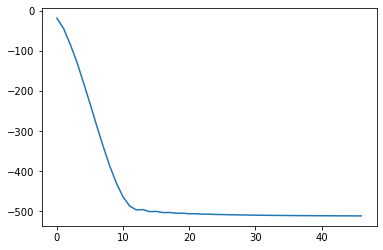

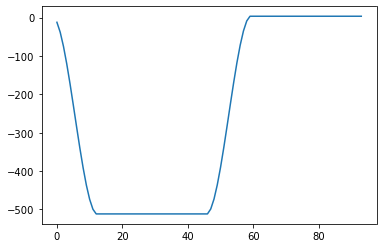

In [9]:
plt.figure()
plt.plot(Iterations[0].top_cyl_RPS_PI)
plt.figure()
plt.plot(Iterations[0].top_cyl_RPS)

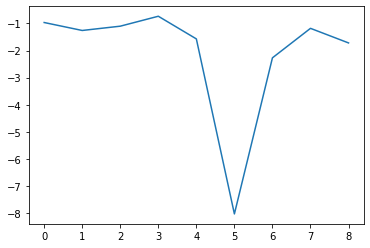

In [10]:
plt.figure()
plt.plot(total_rewards)

In [ ]:
iteration_num=15
filename='data_iteration_'+str(iteration_num)+'.pickle'
with open(filename, 'rb') as handle:
    data = pickle.load(handle)